# Yu-Gutnisky-2016 - A DataJoint example
This notebook presents data and results associated with the following papers:

>Jianing Yu, Diego A Gutnisky, S Andrew Hires & Karel Svoboda1. "Layer 4 fast-spiking interneurons filter thalamocortical signals during active somatosensation" (2016) Nat Neurosci (https://dx.doi.org/10.1038/nn.4412)

Original data shared here: http://crcns.org/data-sets/ssc/ssc-7

The data in original NWB 1 format (.nwb) have been ingested into a DataJoint data pipeline presented below. This notebook demonstrates the queries, processing, and reproduction of several figures from the paper.

Data are also exported into NWB 2.0 format. See NWB export code [here](../scripts/datajoint_to_nwb.py)

In [1]:
from datetime import datetime
import os
os.chdir('..')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import datajoint as dj
from pipeline import (reference, subject, acquisition, stimulation, analysis, virus,
                      intracellular, extracellular, behavior, utilities)

Connecting root@127.0.0.1:3306


In [2]:
%matplotlib inline 

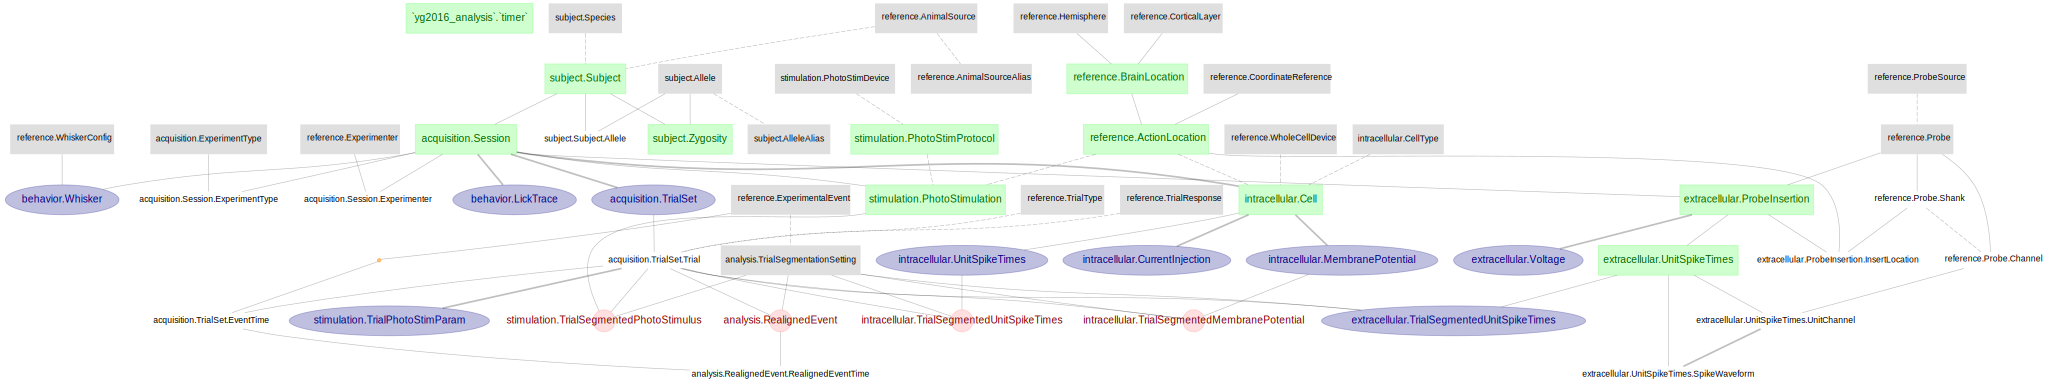

In [3]:
all_erd = (dj.ERD(reference) + dj.ERD(subject)
           + dj.ERD(acquisition) + dj.ERD(analysis)
           + dj.ERD(stimulation) + dj.ERD(behavior)
           + dj.ERD(extracellular) + dj.ERD(intracellular))
dj.ERD(all_erd)

Next, we define 3 utility functions to help with extracting and segmenting data:
+ ***segment_timeseries*** - segment any timeseries (e.g. Vm, lick traces) or event-series (e.g. spike times) to some specified time (e.g. trial start time or first touch time)
+ ***build_raster_and_PSTH*** - from spike times, compute PSTH
+ ***build_trial_segmented_timeseries*** - the main processing routine, to extract Vm, behavioral data, spikes, etc. and segment, aligned to i) trial-start and ii) touch onset

And 2 plotting functions:
+ ***plot_trial_start_align*** - plot behavioral and ephys daata from a single trial, aligned to trial-start time
+ ***plot_touch_aligned*** - plot trial aggregated behavioral, ephys, and spike PSTH, aligned to first touch onset

In [4]:
def segment_timeseries(data, timestamps, event_times, pre_dur, post_dur):
    d_seg = [data[np.logical_and(timestamps > t - pre_dur, timestamps <= t + post_dur)] for t in event_times]
    t_seg = [timestamps[np.logical_and(timestamps > t - pre_dur, timestamps <= t + post_dur)] - t for t in event_times]
    return d_seg, t_seg

In [5]:
# trial-average spike histogram
def build_raster_and_PSTH(spike_times, timerange, bin_size=0.05):
    stacked_spikes = np.hstack(spike_times)
    stacked_trials = np.hstack([np.full_like(r, idx) if r.size > 0 else [] for idx, r in enumerate(spike_times)])
    spk_counts, spk_edges = np.histogram(stacked_spikes, bins=int((timerange[-1] - timerange[0]) / bin_size), range=timerange)
    spk_rates = spk_counts / np.diff(spk_edges) / len(spike_times)
    return stacked_spikes, stacked_trials, spk_rates, spk_edges[:-1]

In [6]:
def build_trial_segmented_timeseries(session_key):
    trial_start, trial_stop = (acquisition.TrialSet.Trial & session_key).fetch('start_time', 'stop_time')
    
    # get behavioral data from the principal whisker
    dis_to_pole, touch_on, touch_off, whisk_pos, whisk_curv, b_tvec = (behavior.Whisker 
                                                                       & session_key
                                                                       & 'principal_whisker=1').fetch1(
        'distance_to_pole', 'touch_onset', 'touch_offset', 'whisker_angle', 'whisker_curvature', 'behavior_timestamps')
    
    touch_on = np.where(touch_on==1, touch_on, np.nan)
    touch_off = np.where(touch_off==1, touch_off, np.nan)
    
    if extracellular.UnitSpikeTimes & session_key:
        spike_times = (extracellular.UnitSpikeTimes & session_key).fetch1('spike_times')
    elif intracellular.UnitSpikeTimes & session_key:
        spike_times = (intracellular.UnitSpikeTimes & session_key).fetch1('spike_times')
    
    lick_traces, l_tvec = (behavior.LickTrace & session_key).fetch1('lick_trace', 'lick_trace_timestamps')
    
    # ---- align to trial start ----
    # segment: 0 to 5s of trial_start
    event_times = trial_start
    pre_dur = 0
    post_dur = 5
    b_fs = round(1/np.median(np.diff(b_tvec)))
    
    segmented_spikes = [spike_times[np.logical_and(spike_times > t - pre_dur, 
                                               spike_times <= t + post_dur)] - t for t in event_times]
    segmented_lick_traces, segmented_ltvec = segment_timeseries(lick_traces, l_tvec, event_times, pre_dur, post_dur)
    segmented_behav = {k: segment_timeseries(d, b_tvec, event_times, pre_dur, post_dur)[0]
                   for k, d in zip(('touch_on', 'touch_off', 'whisk_pos', 'whisk_curv'), 
                                   (touch_on, touch_off, whisk_pos, whisk_curv))}
    segmented_btvec = segment_timeseries(whisk_pos, b_tvec, event_times, pre_dur, post_dur)[1]
    
    trial_start_aligned = {'pre_start': pre_dur, 'post_start':post_dur, 'spikes': segmented_spikes,
                           'licks': segmented_lick_traces, 'lick_times': segmented_ltvec,
                           'whiskers': segmented_behav, 'whisker_times': segmented_btvec}
    
    if intracellular.MembranePotential & session_key:
        Vm, v_tvec = (intracellular.MembranePotential & cell_key).fetch1('membrane_potential', 'membrane_potential_timestamps')
        segmented_Vm, segmented_vtvec = segment_timeseries(Vm, v_tvec, event_times, pre_dur, post_dur)
        trial_start_aligned.update(Vm=segmented_Vm, Vm_times=segmented_vtvec)
    
    # ---- align to touch onsets ----
    # touch times
    touch_onset = b_tvec[touch_on==1]
    touch_offset = b_tvec[touch_off==1]
    # inter-touch-interval - of each touch
    iti = (touch_onset[1:] - touch_offset[:-1]) 
    
    # get touch-onset that has inter-touch-interval of at least 25ms
    touch_onset = touch_onset[:-1][iti > 25e-3]
    # segment: -25ms to 50ms of touch-time
    pre_touch = 25e-3
    post_touch = 50e-3
    # touch-aligned spike-times
    touch_aligned_spikes = [spike_times[np.logical_and(spike_times > t_touch - pre_touch, 
                                                       spike_times < t_touch + post_touch)] - t_touch
                            for t_touch in touch_onset]
    # touch-aligned Whisker Curvature
    touch_aligned_curvature, touch_aligned_btvec = segment_timeseries(whisk_curv, b_tvec, touch_onset, pre_touch, post_touch)
    touch_aligned_curvature = [np.where((k - k[:100].mean()) < 0, k - k.mean(), 0) for k in touch_aligned_curvature]
    
    # psth
    stacked_spikes, stacked_trials, spk_rates, spk_edges = build_raster_and_PSTH(
        touch_aligned_spikes, (-pre_touch, post_touch), bin_size=0.001)
    
    touch_aligned = {'pre_touch': pre_touch, 'post_touch':post_touch, 'spikes': touch_aligned_spikes,
                     'whisk_curv': touch_aligned_curvature, 'whisker_times': touch_aligned_btvec,
                     'stacked_spikes': stacked_spikes, 'stacked_trials': stacked_trials,
                     'spk_rates': spk_rates, 'spk_edges': spk_edges}
    
    if intracellular.MembranePotential & session_key:
        # touch-aligned Vm
        touch_aligned_Vm, touch_aligned_vtvec = segment_timeseries(Vm, v_tvec, touch_onset, pre_touch, post_touch)
        touch_aligned.update(Vm=touch_aligned_Vm, Vm_times=touch_aligned_vtvec)
    
    return trial_start_aligned, touch_aligned

In [7]:
def plot_trial_start_aligned(trial_num, trial_start_aligned):
    pre_dur = trial_start_aligned['pre_start']
    post_dur = trial_start_aligned['post_start']
    l_tvec = trial_start_aligned['lick_times'][trial_num]
    licks = trial_start_aligned['licks'][trial_num]
    b_tvec = trial_start_aligned['whisker_times'][trial_num]
    whisk_curv = trial_start_aligned['whiskers']['whisk_curv'][trial_num]
    touch_on = trial_start_aligned['whiskers']['touch_on'][trial_num]
    whisk_pos = trial_start_aligned['whiskers']['whisk_pos'][trial_num]
    spikes = trial_start_aligned['spikes'][trial_num]
    
    
    if 'Vm' in trial_start_aligned:
        fig, axs = plt.subplots(5, 1, figsize=(12, 6))
        fig.subplots_adjust(hspace=0.01)
        
        for x in b_tvec[touch_on==1]:
            axs[3].axvline(x, 0.25, 0.75, color='deepskyblue')
        axs[3].plot(trial_start_aligned['Vm_times'][trial_num], trial_start_aligned['Vm'][trial_num], 'k')
        axs[4].plot(b_tvec, whisk_pos, 'g')
        axs[4].plot(b_tvec, whisk_pos * touch_on, '.', c='deepskyblue')
            
    else:
        fig, axs = plt.subplots(4, 1, figsize=(12, 6))
        fig.subplots_adjust(hspace=0.01)
        
        for x in b_tvec[touch_on==1]:
            axs[2].axvline(x, 0.25, 0.75, color='deepskyblue')
        axs[3].plot(b_tvec, whisk_pos, 'g')
        axs[3].plot(b_tvec, whisk_pos * touch_on, '.', c='deepskyblue')

    axs[0].plot(l_tvec, np.where(licks > 0, licks, np.nan), '.', color='deeppink')
    axs[1].plot(b_tvec, whisk_curv, 'deepskyblue')
    for x in spikes:
        axs[2].axvline(x, 0.35, 0.65, color='k')
    
    for a in axs:
        a.set_xlim((-pre_dur, post_dur))
        a.spines['right'].set_visible(False)
        a.spines['top'].set_visible(False)
        a.spines['left'].set_visible(False)
        a.spines['bottom'].set_visible(False)
        a.set_yticks([])
        a.set_xlim((0.5, 2))
    for a in axs[:-1]:
        a.set_xticks([])

In [8]:
def plot_touch_aligned(touch_aligned):
    pre_dur = touch_aligned['pre_touch']
    post_dur = touch_aligned['post_touch']
    b_tvec = touch_aligned['whisker_times']
    whisk_curv = touch_aligned['whisk_curv']
    stacked_spikes = touch_aligned['stacked_spikes']
    stacked_trials = touch_aligned['stacked_trials']
    spk_rates = touch_aligned['spk_rates']
    spk_edges = touch_aligned['spk_edges']
    
    if 'Vm' in trial_start_aligned:
        fig, axs = plt.subplots(4, 1, figsize=(4, 8))
        rand_trials = np.random.randint(len(touch_aligned['Vm']), size=20)
        for k in rand_trials:
            axs[2].plot(touch_aligned['Vm_times'][k], touch_aligned['Vm'][k], color='gray', alpha=0.2)
        axs[3].bar(spk_edges, spk_rates, width=0.001, color='k')
    else:
        fig, axs = plt.subplots(3, 1, figsize=(4, 6))

        axs[2].bar(spk_edges, spk_rates, width=0.001, color='k')
        
    rand_trials = np.random.randint(len(whisk_curv), size=20)
    for k in rand_trials:
        axs[0].plot(b_tvec[k], whisk_curv[k], color='b', alpha=0.5)
    rand_trials = np.random.randint(len(stacked_spikes), size=40)
    axs[1].plot(stacked_spikes[rand_trials], stacked_trials[rand_trials], '|', color='k')
        
    # cosmetic
    for a in axs[:-1]:
        a.set_axis_off()
        a.set_xlabel([])
        a.set_xlim((-pre_dur, post_dur))

    for a in axs[1:]:
        a.axvline(x=0, color='b')
        a.set_xlim((-pre_dur, post_dur))

    axs[-1].set_xlabel('Time from touch onset')
    axs[-1].spines["top"].set_visible(False)
    axs[-1].spines["right"].set_visible(False)

## Replication of Figure 1 (b, d) - VPM

Plot the trial-aligned behavior and ephys data from one representative trial

Plot ephys, spike PSTH for 3 cells:
+ ANM199549_20130530
+ ANM199552_20130602
+ ANM186997_20130321

In [9]:
session_key = acquisition.Session & 'session_id = "ANM199549_20130530"'
trial_start_aligned, touch_aligned = build_trial_segmented_timeseries(session_key)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in less


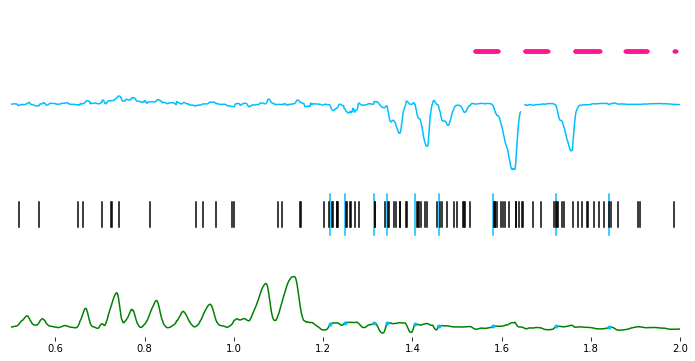

In [10]:
plot_trial_start_aligned(348, trial_start_aligned)

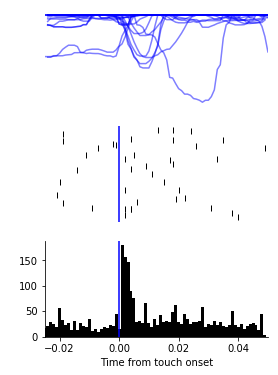

In [11]:
plot_touch_aligned(touch_aligned)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in less


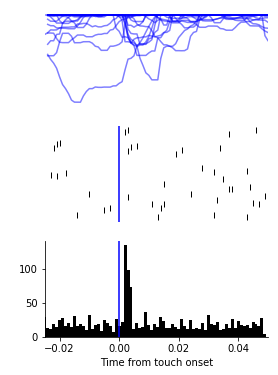

In [12]:
session_key = acquisition.Session & 'session_id = "ANM199552_20130602"'
trial_start_aligned, touch_aligned = build_trial_segmented_timeseries(session_key)
plot_touch_aligned(touch_aligned)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in less


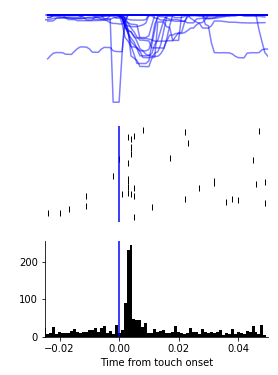

In [13]:
session_key = acquisition.Session & 'session_id = "ANM186997_20130321"'
trial_start_aligned, touch_aligned = build_trial_segmented_timeseries(session_key)
plot_touch_aligned(touch_aligned)

## Replication of Figure 2 (b, d) - L4 excitatory cell
Plot the trial-aligned behavior and ephys data from one representative trial

Plot ephys, spike PSTH for 3 cells:
+ JY0861AAAA
+ JY0520AAAC
+ JY1008AAAA

In [14]:
cell_key = intracellular.Cell & {'session_id': 'JY0861AAAA'}
trial_start_aligned, touch_aligned = build_trial_segmented_timeseries(cell_key)

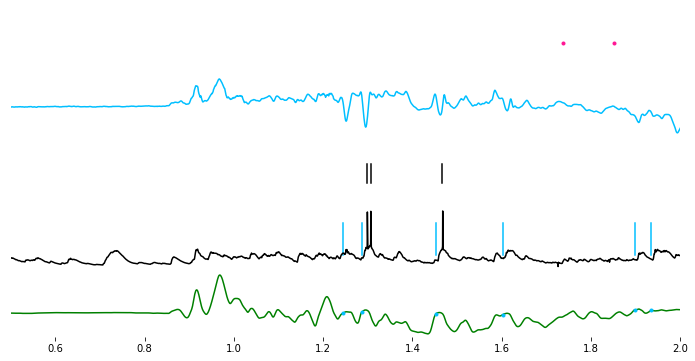

In [15]:
plot_trial_start_aligned(20, trial_start_aligned)

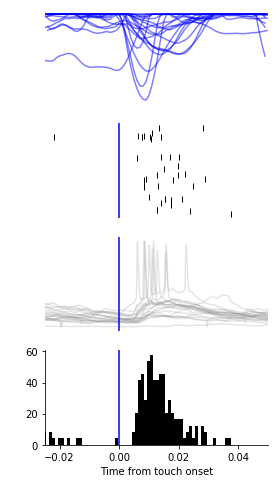

In [16]:
plot_touch_aligned(touch_aligned)

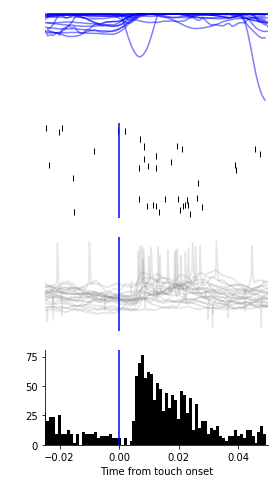

In [21]:
cell_key = intracellular.Cell & {'session_id': 'JY0520AAAC'}
trial_start_aligned, touch_aligned = build_trial_segmented_timeseries(cell_key)
plot_touch_aligned(touch_aligned)

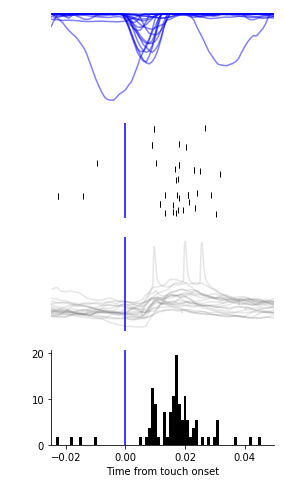

In [22]:
cell_key = intracellular.Cell & {'session_id': 'JY1008AAAA'}
trial_start_aligned, touch_aligned = build_trial_segmented_timeseries(cell_key)
plot_touch_aligned(touch_aligned)